# Import libraries

[Paper reference](https://ieeexplore.ieee.org.remotexs.ntu.edu.sg/stamp/stamp.jsp?tp=&arnumber=8861550&tag=1)

In [1]:
import pandas as pd
import pickle
import time
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
# import matplotlib as plt
from copy import deepcopy


from IPython.core.display import display, HTML
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)
display(HTML("<style>.container { width:99% !important; }</style>"))

<ipython-input-1-d1c10c007e8c>:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# General Functions

In [2]:
def dump_file(file_path, file_name, data_to_dump):
    import pickle
    with open(f'{file_path}/{file_name}.pkl', 'wb') as file:
        pickle.dump(data_to_dump, file)
        
def load_file(file_path, file_name):
    import pickle
    with open(f'{file_path}/{file_name}.pkl', 'rb') as file:
        output_file = pickle.load(file)
    return output_file

In [3]:
folder_path = '01_Paper_1'

In [58]:
# ========== save files ===============
dump_file(file_path=folder_path, file_name='stock_tickers', data_to_dump=stock_ticker)
dump_file(file_path=folder_path, file_name='stock_tickers_formatted_before_map', data_to_dump=stock_ticker_formatted)
dump_file(file_path=folder_path, file_name='stock_tickers_formatted', data_to_dump=stock_ticker_formatted)
dump_file(file_path=folder_path, file_name='tickers_map', data_to_dump=tickers_map)
dump_file(file_path=folder_path, file_name='financial_data_by_tickers', data_to_dump=financial_data_by_tickers)
dump_file(file_path=folder_path, file_name='financial_data_by_tickers_timeframe_final', data_to_dump=financial_data_by_tickers_timeframe_final)

In [193]:
dump_file(file_path=folder_path, file_name='financial_data_filled', data_to_dump=financial_data_filled)
dump_file(file_path=folder_path, file_name='financial_data_relative_return', data_to_dump=financial_data_relative_return)
dump_file(file_path=folder_path, file_name='financial_data_trend_standardized', data_to_dump=financial_data_trend_standardized)

# 1. Getting the dataset required

## Automating data download

In [55]:
stock_ticker = load_file(file_path=folder_path, file_name='stock_tickers')

In [56]:
stock_ticker_formatted_before_map = []
for st in stock_ticker:
    stock_ticker_formatted_before_map.append(st.split('-')[0].split(' ')[0])

In [57]:
# fixing the tickers to download the datasets, map to the correct ticker in request url

stock_ticker_formatted = deepcopy(stock_ticker_formatted_before_map)

tickers_map = {1: 'AMR', 7: 'ABI_0', 52: 'ABK', 63: 'TSO', 68: 'WLP', 69: 'AOC', 79: 'AA', 83: 'DV', 106: 'FO', 
               108: 'BF.B', 218: 'DG_1', 240: 'DOW', 241: 'CSC', 243: 'ERTS', 261: 'EL', 293: 'FRE', 294: 'FNM', 
              296:'NWS.A', 301: 'CZN', 311: 'WPO', 356: 'SLE', 362: 'IACI', 376: 'Q_1', 397: 'LIZ', 408: 'EK', 
              414: 'LTR', 415: 'LTD', 416: 'SAI', 418: 'LEH_0', 452: 'KFT', 480: 'MOT', 488: 'MNST_0', 498: 'FPL',
              569: 'PMTC', 636: 'MHP', 648: 'WFR', 668: 'GCI', 712: 'VIA.B', 713: 'JDSU', 732: 'WFMI', 738: 'WM', 
               739: 'WM_0', 762: 'ZMH'}

for n, st in enumerate(stock_ticker_formatted):
    if n in list(tickers_map.keys()):
        stock_ticker_formatted[n] = tickers_map[n]

In [94]:
# automate downloading of files using requests library
import requests
import pickle
import csv

tickers_not_retrieved = [] # may be file name error
financial_data_by_tickers = []
total_tickers = len(stock_ticker_formatted)

for n, st in enumerate(stock_ticker_formatted):
    url = f"https://web.archive.org/web/20180809015717/http://www.stockpup.com/data/{st}_quarterly_financial_data.csv"

    with requests.Session() as s:
        try:
            download = s.get(url)
            decoded_content = download.content.decode('utf-8')
            csv_lines = list(csv.reader(decoded_content.splitlines(), delimiter=','))
            df_financial_data_per_ticker = pd.DataFrame(csv_lines, columns=csv_lines[0]).drop(index=0)
            df_financial_data_per_ticker['ticker'] = st
            financial_data_by_tickers.append(df_financial_data_per_ticker)
            print(f'financial data of {n}/{total_tickers} retrieved, {st} appended')
        except Exception as e:
            print(f'ticker not retrieved {st} financial data of {n}/{total_tickers} NOT RETRIEVED', 'error:', e)
            tickers_not_retrieved.append(n)

financial data of 0/765 retrieved, A appended
financial data of 1/765 retrieved, AMR appended
financial data of 2/765 retrieved, AAN appended
financial data of 3/765 retrieved, AAP appended
financial data of 4/765 retrieved, AAPL appended
financial data of 5/765 retrieved, ABBV appended
financial data of 6/765 retrieved, ABC appended
financial data of 7/765 retrieved, ABI_0 appended
financial data of 8/765 retrieved, ABMD appended
financial data of 9/765 retrieved, ABT appended
financial data of 10/765 retrieved, ACAS appended
financial data of 11/765 retrieved, ACC appended
financial data of 12/765 retrieved, ACIW appended
financial data of 13/765 retrieved, ACM appended
financial data of 14/765 retrieved, ACN appended
financial data of 15/765 retrieved, ACS appended
financial data of 16/765 retrieved, ACV appended
financial data of 17/765 retrieved, ACXM appended
financial data of 18/765 retrieved, ADBE appended
financial data of 19/765 retrieved, ADCT appended
financial data of 20/7

# 2. Data Preprocessing

## Choosing the Stocks

In [7]:
financial_data_by_tickers = load_file(file_path=folder_path, file_name='financial_data_by_tickers')
stock_ticker_formatted_before_map = load_file(file_path=folder_path, file_name='stock_tickers_formatted_before_map')

In [30]:
# 102 leading stocks chosen. Assumption to be made that we find top 102 stocks that represents about 51% of market, then get the required timeline
df_top_200 = pd.read_csv(f'{folder_path}/top_200_stocks_by_components.csv')
top_200_list = list(df_top_200['Symbol'])


# check stocks in list
top_200_idx = []
for n, st in enumerate(stock_ticker_formatted_before_map):
    if st in top_200_list:
        top_200_idx.append(n)
        
# 95 stocks in top 102 in dataframes list
financial_data_by_tickers_final = []
for idx in top_200_idx:
    financial_data_by_tickers_final.append(financial_data_by_tickers[idx])
    
# out of 95 stocks take only the relevant quarters from Q1 1996 to Q4 2017
financial_data_by_tickers_timeframe = []
for df in financial_data_by_tickers_final:
    df_temp = df[(df['Quarter end'] >= '1996-03-29') & (df['Quarter end'] <= '2017-12-31')]
    financial_data_by_tickers_timeframe.append(df_temp)

In [37]:
# get only tickers with all 88 observations from Q1 1996 to Q4 2017 present, else drop them
for n, df in enumerate(financial_data_by_tickers_timeframe):
    if df.shape[0] != 88:
        del financial_data_by_tickers_timeframe[n]

In [38]:
# check shapes of dfs
for df in financial_data_by_tickers_timeframe:
    print(df.shape)

(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)
(88, 42)


In [51]:
# from dataframes that have all 88 observations, we select the top 70 then do feature dropping

# merge dataframe, get rank, sort them and select top 70

df_financial_data_top_97 = pd.concat(financial_data_by_tickers_timeframe). \
merge(df_top_200, left_on='ticker', right_on='Symbol'). \
sort_values(by='#', ascending=True). \
drop(columns = list(df_top_200.columns))

financial_data_by_tickers_timeframe_sorted = []
ticker_list = list(df_financial_data_top_97['ticker'].unique())
for t in ticker_list:
    df_temp = df_financial_data_top_97[df_financial_data_top_97['ticker'] == t]. \
    sort_values(by='Quarter end', ascending=True). \
    reset_index(drop=True)
    
    financial_data_by_tickers_timeframe_sorted.append(df_temp)
    
financial_data_by_tickers_timeframe_final = deepcopy(financial_data_by_tickers_timeframe_sorted[0:70])

## Feature Dropping

In [6]:
financial_data_by_tickers_timeframe_final = load_file(file_path=folder_path, file_name='financial_data_by_tickers_timeframe_final')

In [7]:
# An assumption is to select 21 features that have all values present for 88 data points or are good features by logical reasoning and per research on important fundamental features

cols_wanted = ['Quarter end', 'Assets', 'Current Assets', 'Liabilities', 'Current Liabilities', 'Shareholders equity','Revenue', 'Earnings', 'EPS basic', 'EPS diluted', 'Price', 'Price high', 'Price low', 'ROE', 
               'P/B ratio', 'P/E ratio', 'Cumulative dividends per share', 'Dividend payout ratio', 'Long-term debt to equity ratio','Net margin', 'Asset turnover', 'Free cash flow per share', 'ticker'] 
financial_data_by_tickers_timeframe_cols_selected = []
for df in financial_data_by_tickers_timeframe_final:
    df_temp = df[cols_wanted]
    financial_data_by_tickers_timeframe_cols_selected.append(df_temp)

In [19]:
financial_data_cols_converted = []

for df in financial_data_by_tickers_timeframe_cols_selected:
    cols_convert = list(df.drop(columns=['Quarter end', 'ticker']).columns)
    df = df.replace({'0': 0, 'None':0, None: 0})
    df[cols_convert] = df[cols_convert].astype(float)
    financial_data_cols_converted.append(df)

In [23]:
financial_data_cols_converted[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Quarter end                     88 non-null     object 
 1   Assets                          88 non-null     float64
 2   Current Assets                  88 non-null     float64
 3   Liabilities                     88 non-null     float64
 4   Current Liabilities             88 non-null     float64
 5   Shareholders equity             88 non-null     float64
 6   Revenue                         88 non-null     float64
 7   Earnings                        88 non-null     float64
 8   EPS basic                       88 non-null     float64
 9   EPS diluted                     88 non-null     float64
 10  Price                           88 non-null     float64
 11  Price high                      88 non-null     float64
 12  Price low                       88 non

## Calculating Relative Return of Stocks

`absolute quarterly return of stock price`: (this quarter closing price) - (last quarter closing price) / (last quarter closing price)

1. find out price of dija stocks and its absolute quarterly return per quarter
2. calculate the absolute quarterly return of stocks per quarter 
3. get relative return w.r.t Dija
4. relative_return = absolute_quarterly_return_of_stock - absolute_quarterly_return_of_dija

In [182]:
# function to find absolute quarterly return in price for each ticker

def relative_return_djia(df):
    """
    This functions gets the relative return of quarterly price of each ticker with respect to the Dow Jones Industrial Average
    """

    df_djia = pd.read_csv(f"{folder_path}/DIJA_absolute_return.csv")
    np_djia_return = df_djia['Absolute Return'].to_numpy()

    df_relative_return = deepcopy(df)
    np_relative_return = np.zeros(len(df_relative_return))
    np_absolute_return = np.zeros(len(df_relative_return))
    np_price = df_relative_return['Price'].to_numpy()
    
    for n, price in enumerate(np_price):
        if n==0:
            np_relative_return[0] = 0
        else:
            absolute_return = (np_price[n] - np_price[n-1])/np_price[n-1]
            np_absolute_return[n] = absolute_return
    
    for i in range(88):
        np_relative_return[i] = np_absolute_return[i] - np_djia_return[i]
        
    # mean substitution for first quarter of 1996
    np_relative_return[0] = np_relative_return.mean()

    df_relative_return['Relative Return DJIA'] = np_relative_return
    
    return df_relative_return

In [183]:
financial_data_relative_return = []
for df in financial_data_cols_converted:
    financial_data_relative_return.append(relative_return_djia(df))

<ipython-input-182-74c00f9e9a5f>:20: RuntimeWarning: divide by zero encountered in double_scalars
  absolute_return = (np_price[n] - np_price[n-1])/np_price[n-1]


In [184]:
financial_data_relative_return[0]

,Quarter end,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Revenue,Earnings,EPS basic,EPS diluted,Price,Price high,Price low,ROE,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Net margin,Asset turnover,Free cash flow per share,ticker,Relative Return DJIA
0,1996-03-29,5.234000e+09,4.277000e+09,3.178000e+09,2.273000e+09,2.056000e+09,2.185000e+09,-7.400000e+08,-5.99,0.00,1.04,1.27,0.82,-0.2443,1.28,21.57,0.03,0.0000,0.1474,0.0000,1.81,-0.11,AAPL,1.456728
1,1996-06-28,5.345000e+09,4.454000e+09,3.325000e+09,1.926000e+09,2.020000e+09,2.179000e+09,-3.200000e+07,-0.26,0.00,0.86,1.03,0.70,-0.3197,1.46,0.00,0.03,0.0000,0.4698,0.0000,1.80,0.08,AAPL,1.020458
2,1996-09-27,5.364000e+09,4.515000e+09,3.306000e+09,2.003000e+09,2.058000e+09,2.321000e+09,2.500000e+07,0.21,0.00,0.73,0.89,0.57,-0.3656,1.26,0.00,0.03,0.0000,0.4611,0.0000,1.75,0.11,AAPL,3.717138
3,1996-12-27,5.272000e+09,4.419000e+09,3.330000e+09,2.044000e+09,1.942000e+09,2.129000e+09,-1.200000e+08,-0.96,0.00,0.88,0.99,0.76,-0.4294,1.49,0.00,0.03,0.0000,0.4892,0.0000,1.66,0.02,AAPL,8.984578
4,1997-03-28,4.487000e+09,3.642000e+09,3.245000e+09,2.011000e+09,1.242000e+09,1.601000e+09,-7.080000e+08,-5.64,0.00,0.69,0.83,0.54,-0.4599,1.23,0.00,0.03,0.0000,0.7665,0.0000,1.61,0.02,AAPL,1.837868
5,1997-06-27,4.341000e+09,3.493000e+09,3.145000e+09,1.910000e+09,1.196000e+09,1.737000e+09,-5.600000e+07,-0.44,0.00,0.61,0.71,0.52,-0.5337,1.74,0.00,0.03,0.0000,0.7952,0.0000,1.60,-0.06,AAPL,14.081110
6,1997-09-26,4.233000e+09,3.424000e+09,3.033000e+09,1.818000e+09,1.200000e+09,1.614000e+09,-1.610000e+08,-1.26,0.00,0.76,1.06,0.46,-0.7491,2.24,0.00,0.03,0.0000,0.7925,0.0000,1.54,0.05,AAPL,3.675242
7,1997-12-26,4.126000e+09,3.373000e+09,2.882000e+09,1.669000e+09,1.244000e+09,1.578000e+09,4.700000e+07,0.37,0.33,0.67,0.88,0.46,-0.7194,2.03,0.00,0.03,0.0000,0.7653,0.0000,1.52,0.04,AAPL,-0.586413
8,1998-03-27,3.963000e+09,3.213000e+09,2.575000e+09,1.384000e+09,1.388000e+09,1.405000e+09,5.500000e+07,0.42,0.38,0.73,1.00,0.46,-0.0915,2.21,0.00,0.03,0.0000,0.6866,0.0000,1.52,0.04,AAPL,10.221135
9,1998-06-26,4.041000e+09,3.375000e+09,2.555000e+09,1.389000e+09,1.486000e+09,1.402000e+09,1.010000e+08,0.76,0.65,1.00,1.13,0.88,0.0316,2.70,0.00,0.03,0.0000,0.6413,0.0070,1.47,0.04,AAPL,2.070150


## File Missing Entries

Done before `Trend standardization`

In [185]:
def missing_entries(df):
    """
    1. change each series to a numpy array
    2. check if all data points present (88 data points), if yes pass, if no then do mean substitution iterating in reverse
    2. if value == 0, val(idx+1) + val(idx-1) / 2 , else value == val(idx)
    """
    from copy import deepcopy
    
    df_filled = deepcopy(df)
    cols = list(df_filled.drop(columns=['Quarter end', 'ticker']).columns)
    for c in cols:
        df_temp = df_filled[c]
        df_temp_check = df_temp[df_temp != 0]
        if df_temp_check.shape[0] != 88:
            np_series = df_temp.to_numpy()
#             np_series_before = deepcopy(np_series)
            for n, val in reversed(list(enumerate(np_series))):
                if ((n == 0) and (val == 0)) or ((n == 87) and (val == 0)):
                    np_series[n] = (np_series[n] + np_series[n-1]) / 2
                elif (val == 0):
                    np_series[n] = (np_series[n-1] + np_series[n+1]) / 2
                else:
                    np_series[n] = np_series[n]
            df_filled[c] = np_series
    #         print(c, np_series, '\n', np_series_before)
    
    return df_filled

In [186]:
# fill missing entries for all dfs
financial_data_filled = []
for df in financial_data_relative_return:
    financial_data_filled.append(missing_entries(df))

In [126]:
financial_data_filled[0]

,Quarter end,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Revenue,Earnings,EPS basic,EPS diluted,Price,Price high,Price low,ROE,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Net margin,Asset turnover,Free cash flow per share,ticker,Relative Return DJIA
0,1996-03-29,5.234000e+09,4.277000e+09,3.178000e+09,2.273000e+09,2.056000e+09,2.185000e+09,-7.400000e+08,-5.99,1.945000,1.04,1.27,0.82,-0.2443,1.28,21.570,0.03,1.252500e-01,1.474000e-01,0.105600,1.81,-0.110,AAPL,-1.828901
1,1996-06-28,5.345000e+09,4.454000e+09,3.325000e+09,1.926000e+09,2.020000e+09,2.179000e+09,-3.200000e+07,-0.26,0.005156,0.86,1.03,0.70,-0.3197,1.46,11.485,0.03,3.355606e-21,4.698000e-01,0.000027,1.80,0.080,AAPL,-1.381029
2,1996-09-27,5.364000e+09,4.515000e+09,3.306000e+09,2.003000e+09,2.058000e+09,2.321000e+09,2.500000e+07,0.21,0.010313,0.73,0.89,0.57,-0.3656,1.26,1.400,0.03,6.711211e-21,4.611000e-01,0.000055,1.75,0.110,AAPL,-4.175122
3,1996-12-27,5.272000e+09,4.419000e+09,3.330000e+09,2.044000e+09,1.942000e+09,2.129000e+09,-1.200000e+08,-0.96,0.020625,0.88,0.99,0.76,-0.4294,1.49,2.800,0.03,1.342242e-20,4.892000e-01,0.000109,1.66,0.020,AAPL,-9.418520
4,1997-03-28,4.487000e+09,3.642000e+09,3.245000e+09,2.011000e+09,1.242000e+09,1.601000e+09,-7.080000e+08,-5.64,0.041250,0.69,0.83,0.54,-0.4599,1.23,5.600,0.03,2.684485e-20,7.665000e-01,0.000219,1.61,0.020,AAPL,-2.312751
5,1997-06-27,4.341000e+09,3.493000e+09,3.145000e+09,1.910000e+09,1.196000e+09,1.737000e+09,-5.600000e+07,-0.44,0.082500,0.61,0.71,0.52,-0.5337,1.74,11.200,0.03,5.368969e-20,7.952000e-01,0.000438,1.60,-0.060,AAPL,-16.662054
6,1997-09-26,4.233000e+09,3.424000e+09,3.033000e+09,1.818000e+09,1.200000e+09,1.614000e+09,-1.610000e+08,-1.26,0.165000,0.76,1.06,0.46,-0.7491,2.24,22.400,0.03,1.073794e-19,7.925000e-01,0.000875,1.54,0.050,AAPL,-3.305219
7,1997-12-26,4.126000e+09,3.373000e+09,2.882000e+09,1.669000e+09,1.244000e+09,1.578000e+09,4.700000e+07,0.37,0.330000,0.67,0.88,0.46,-0.7194,2.03,44.800,0.03,2.147588e-19,7.653000e-01,0.001750,1.52,0.040,AAPL,0.347391
8,1998-03-27,3.963000e+09,3.213000e+09,2.575000e+09,1.384000e+09,1.388000e+09,1.405000e+09,5.500000e+07,0.42,0.380000,0.73,1.00,0.46,-0.0915,2.21,89.600,0.03,4.295175e-19,6.866000e-01,0.003500,1.52,0.040,AAPL,-11.184244
9,1998-06-26,4.041000e+09,3.375000e+09,2.555000e+09,1.389000e+09,1.486000e+09,1.402000e+09,1.010000e+08,0.76,0.650000,1.00,1.13,0.88,0.0316,2.70,179.200,0.03,8.590351e-19,6.413000e-01,0.007000,1.47,0.040,AAPL,-1.359833


## Trend Standardization

In [187]:
# function for trend standardization
def trend_standardization(df):
    
    """
    1. conver each series to numpy array
    2. get values of standardization, assign to new numpy array
    """
    
    import numpy as np
    from copy import deepcopy
    
    df_standardize = deepcopy(df)
    cols_standardize = list(df_standardize.drop(columns=['Quarter end', 'ticker']).columns)
    for col in cols_standardize:
        np_col = df_standardize[col].to_numpy()
        np_delta = np.zeros(len(np_col))
        for n, val in enumerate(np_col):
            if n == 0:
                np_delta[0] = np_col[0]
            else:
                delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
                np_delta[n] = delta
                
            # mean substitution for 1996 Q1
            np_delta[0] = np_delta.mean()
        df_standardize[col] = np_delta
    
    return df_standardize

In [188]:
financial_data_trend_standardized = []
for n, df in enumerate(financial_data_filled):
    print(n)
    financial_data_trend_standardized.append(trend_standardization(df))

0
1
2
3
4
5
6
7
8
9
10
11
12


<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])


13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta =

34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: divide by zero encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta = (np_col[n] - np_col[n-1]) / (np_col[n-1])
<ipython-input-187-e04f05a9b6a9>:21: RuntimeWarning: invalid value encountered in double_scalars
  delta 

52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


In [160]:
financial_data_trend_standardized[0]

,Quarter end,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Revenue,Earnings,EPS basic,EPS diluted,Price,Price high,Price low,ROE,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Net margin,Asset turnover,Free cash flow per share,ticker,Relative Return DJIA
0,1996-03-29,0.054530,0.045478,0.061899,0.058088,0.053942,0.075105,0.022818,-0.001147,0.099883,0.077414,0.078368,0.084413,-0.102530,0.033678,0.130674,0.189728,0.746084,0.480173,0.202231,-0.010829,-0.004580,AAPL,7.213807
1,1996-06-28,0.021207,0.041384,0.046256,-0.152662,-0.017510,-0.002746,-0.956757,-0.956594,-0.997349,-0.173077,-0.188976,-0.146341,0.308637,0.140625,-0.467548,0.000000,-1.000000,2.187246,-0.999741,-0.005525,-1.727273,AAPL,-0.244886
2,1996-09-27,0.003555,0.013696,-0.005714,0.039979,0.018812,0.065168,-1.781250,-1.807692,1.000000,-0.151163,-0.135922,-0.185714,0.143572,-0.136986,-0.878102,0.000000,1.000000,-0.018519,1.000000,-0.027778,0.375000,AAPL,2.023195
3,1996-12-27,-0.017151,-0.021262,0.007260,0.020469,-0.056365,-0.082723,-5.800000,-5.571429,1.000000,0.205479,0.112360,0.333333,0.174508,0.182540,1.000000,0.000000,1.000000,0.060941,1.000000,-0.051429,-0.818182,AAPL,1.255867
4,1997-03-28,-0.148900,-0.175832,-0.025526,-0.016145,-0.360453,-0.248004,4.900000,4.875000,1.000000,-0.215909,-0.161616,-0.289474,0.071029,-0.174497,1.000000,0.000000,1.000000,0.566844,1.000000,-0.030120,0.000000,AAPL,-0.754446
5,1997-06-27,-0.032538,-0.040912,-0.030817,-0.050224,-0.037037,0.084947,-0.920904,-0.921986,1.000000,-0.115942,-0.144578,-0.037037,0.160470,0.414634,1.000000,0.000000,1.000000,0.037443,1.000000,-0.006211,-4.000000,AAPL,6.204432
6,1997-09-26,-0.024879,-0.019754,-0.035612,-0.048168,0.003344,-0.070812,1.875000,1.863636,1.000000,0.245902,0.492958,-0.115385,0.403598,0.287356,1.000000,0.000000,1.000000,-0.003395,1.000000,-0.037500,-1.833333,AAPL,-0.801632
7,1997-12-26,-0.025278,-0.014895,-0.049786,-0.081958,0.036667,-0.022305,-1.291925,-1.293651,1.000000,-0.118421,-0.169811,0.000000,-0.039648,-0.093750,1.000000,0.000000,1.000000,-0.034322,1.000000,-0.012987,-0.200000,AAPL,-1.105104
8,1998-03-27,-0.039506,-0.047436,-0.106523,-0.170761,0.115756,-0.109632,0.170213,0.135135,0.151515,0.089552,0.136364,0.000000,-0.872811,0.088670,1.000000,0.000000,1.000000,-0.102835,1.000000,0.000000,0.000000,AAPL,-33.194949
9,1998-06-26,0.019682,0.050420,-0.007767,0.003613,0.070605,-0.002135,0.836364,0.809524,0.710526,0.369863,0.130000,0.913043,-1.345355,0.221719,1.000000,0.000000,1.000000,-0.065977,1.000000,-0.032895,0.000000,AAPL,-0.878415


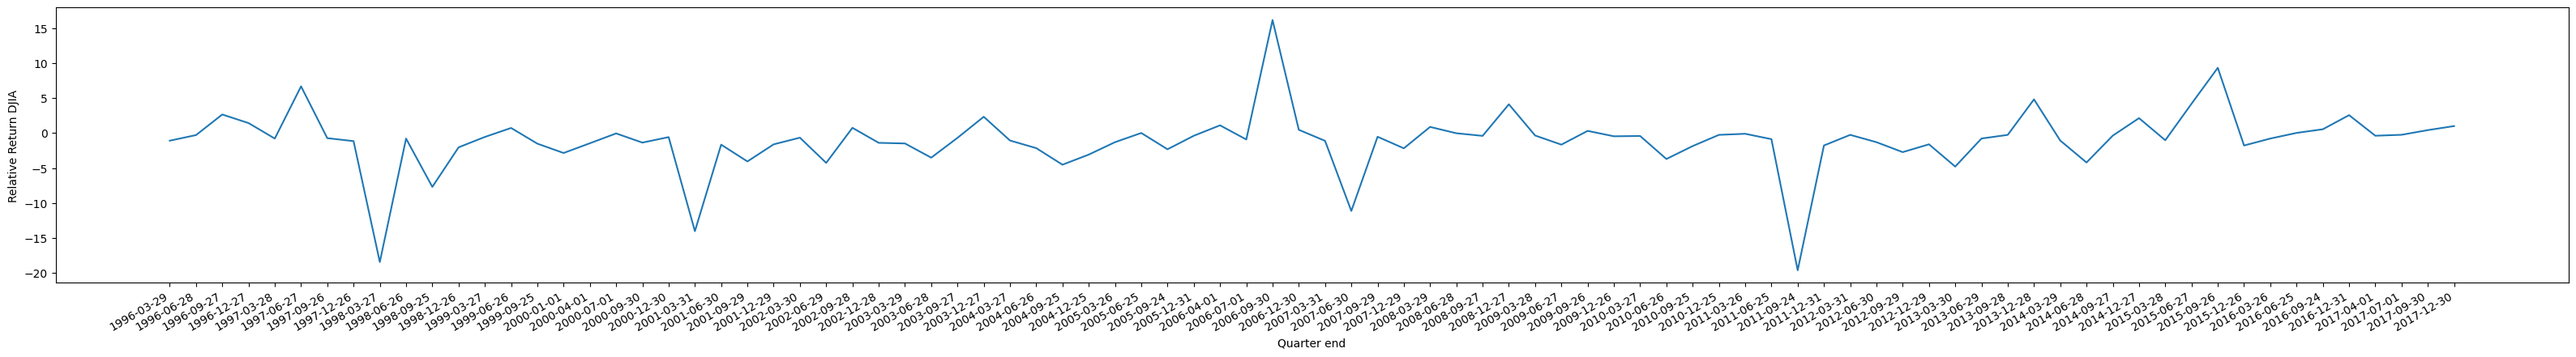

In [190]:
# looking at trend standardized columns
fig = plt.figure(figsize=(40,5))
sb.lineplot(data=financial_data_trend_standardized[0], x="Quarter end", y='Relative Return DJIA')
fig.autofmt_xdate()
plt.show()

# Split dataset into 60-20-20

- 60% training
- 20% validation
- 20% test

In [4]:
financial_data_trend_standardized = load_file(file_path=folder_path, file_name='financial_data_trend_standardized')

In [5]:
financial_data_trend_standardized[0]

,Quarter end,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Revenue,Earnings,EPS basic,EPS diluted,Price,Price high,Price low,ROE,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Net margin,Asset turnover,Free cash flow per share,ticker,Relative Return DJIA
0,1996-03-29,0.054530,0.045478,0.061899,0.058088,0.053942,0.075105,0.022818,-0.001147,0.099883,0.077414,0.078368,0.084413,-0.102530,0.033678,0.130674,0.189728,0.746084,0.480173,0.202231,-0.010829,-0.004580,AAPL,-1.099229
1,1996-06-28,0.021207,0.041384,0.046256,-0.152662,-0.017510,-0.002746,-0.956757,-0.956594,-0.997349,-0.173077,-0.188976,-0.146341,0.308637,0.140625,-0.467548,0.000000,-1.000000,2.187246,-0.999741,-0.005525,-1.727273,AAPL,-0.299486
2,1996-09-27,0.003555,0.013696,-0.005714,0.039979,0.018812,0.065168,-1.781250,-1.807692,1.000000,-0.151163,-0.135922,-0.185714,0.143572,-0.136986,-0.878102,0.000000,1.000000,-0.018519,1.000000,-0.027778,0.375000,AAPL,2.642616
3,1996-12-27,-0.017151,-0.021262,0.007260,0.020469,-0.056365,-0.082723,-5.800000,-5.571429,1.000000,0.205479,0.112360,0.333333,0.174508,0.182540,1.000000,0.000000,1.000000,0.060941,1.000000,-0.051429,-0.818182,AAPL,1.417069
4,1997-03-28,-0.148900,-0.175832,-0.025526,-0.016145,-0.360453,-0.248004,4.900000,4.875000,1.000000,-0.215909,-0.161616,-0.289474,0.071029,-0.174497,1.000000,0.000000,1.000000,0.566844,1.000000,-0.030120,0.000000,AAPL,-0.795442
5,1997-06-27,-0.032538,-0.040912,-0.030817,-0.050224,-0.037037,0.084947,-0.920904,-0.921986,1.000000,-0.115942,-0.144578,-0.037037,0.160470,0.414634,1.000000,0.000000,1.000000,0.037443,1.000000,-0.006211,-4.000000,AAPL,6.661655
6,1997-09-26,-0.024879,-0.019754,-0.035612,-0.048168,0.003344,-0.070812,1.875000,1.863636,1.000000,0.245902,0.492958,-0.115385,0.403598,0.287356,1.000000,0.000000,1.000000,-0.003395,1.000000,-0.037500,-1.833333,AAPL,-0.738995
7,1997-12-26,-0.025278,-0.014895,-0.049786,-0.081958,0.036667,-0.022305,-1.291925,-1.293651,1.000000,-0.118421,-0.169811,0.000000,-0.039648,-0.093750,1.000000,0.000000,1.000000,-0.034322,1.000000,-0.012987,-0.200000,AAPL,-1.159558
8,1998-03-27,-0.039506,-0.047436,-0.106523,-0.170761,0.115756,-0.109632,0.170213,0.135135,0.151515,0.089552,0.136364,0.000000,-0.872811,0.088670,1.000000,0.000000,1.000000,-0.102835,1.000000,0.000000,0.000000,AAPL,-18.429915
9,1998-06-26,0.019682,0.050420,-0.007767,0.003613,0.070605,-0.002135,0.836364,0.809524,0.710526,0.369863,0.130000,0.913043,-1.345355,0.221719,1.000000,0.000000,1.000000,-0.065977,1.000000,-0.032895,0.000000,AAPL,-0.797464


## Standardization For all Features

This is done after partitioning dataset into `Train-Validation-Test of 60%-20%-20%`

In [192]:
financial_data_trend_standardized[51]['Relative Return DJIA'].std()

4.206517548075255

In [52]:
# standardization using StandardScalar sklearn library
def standardize(df_train, df_test):
    
    from sklearn.preprocessing import StandardScaler
    from copy import deepcopy
    
    cols_x = list(df_train.drop(columns=['Quarter end', 'ticker']))
    col_y = 'Relative Return DJIA'
    
    df_train = df_train[cols_x]
    df_test = df_test[cols_x]
    
    df_train_stand = deepcopy(df_train)
    df_test_stand = deepcopy(df_test)
    
    for c in cols_x:
        # fit on training data column
        scale = StandardScaler().fit(df_train_stand[[c]])

        # transform the training data column
        df_train_stand[c] = scale.transform(df_train_stand[[c]])

        # transform the testing data column
        df_test_stand[c] = scale.transform(df_test_stand[[c]])
    
    return df_train_stand, df_test_stand

## Build the FNN model

1. predict the relative return for next quarter for each stock using 60% data to train model
2. predict relative return for validation set
3. predict relative return for test set

## Split into Training/Validation/Test Set

Here we do not need the validation set, instead we validate when building the improved model

In [82]:
# get index for training dataset
idx_60percent = int(0.6*88)
idx_20percent = int(0.2*88)

In [83]:
df_train = financial_data_trend_standardized[0][:idx_60percent]
df_validation = financial_data_trend_standardized[0][idx_60percent: idx_60percent+idx_20percent+1]
df_test = financial_data_trend_standardized[0][idx_80percent:]

In [85]:
df_train.shape, df_validation.shape,df_test.shape

((52, 24), (18, 24), (18, 24))

In [49]:
df_test

,Quarter end,Assets,Current Assets,Liabilities,Current Liabilities,Shareholders equity,Revenue,Earnings,EPS basic,EPS diluted,Price,Price high,Price low,ROE,P/B ratio,P/E ratio,Cumulative dividends per share,Dividend payout ratio,Long-term debt to equity ratio,Net margin,Asset turnover,Free cash flow per share,ticker,Relative Return DJIA
70,2013-09-28,0.035746,0.074275,0.090834,0.202071,0.001581,0.060839,0.088696,0.106525,0.105756,0.075354,0.102946,0.041992,-0.029068,0.142373,0.125123,0.275000,0.380604,-0.001455,-0.027379,-0.022727,0.329670,AAPL,-0.269374
71,2013-12-28,0.087845,0.096349,0.144384,0.231596,0.049656,0.536988,0.740149,0.755716,0.755448,0.147032,0.119499,0.182310,-0.004474,0.133531,0.159370,0.210784,0.022238,-0.047342,-0.017997,-0.023256,1.727273,AAPL,4.801711
72,2014-03-29,-0.085241,-0.122046,-0.101466,-0.196414,-0.073294,-0.207452,-0.217947,-0.198766,-0.198621,0.004935,-0.024099,0.040431,0.049430,-0.049738,-0.012085,0.178138,-0.005180,0.078746,0.006579,0.000000,-0.393939,AAPL,-1.080906
73,2014-06-28,0.080252,-0.036745,0.183778,0.069362,0.006332,-0.179950,-0.242101,-0.889649,-0.889845,0.115609,0.185458,0.036023,0.027668,0.162534,0.074924,0.161512,-0.018049,0.700921,0.010271,-0.011905,-0.345000,AAPL,-4.214184
74,2014-09-27,0.041879,0.008565,0.184209,0.373185,-0.077667,0.125321,0.092798,0.100775,0.109375,0.164902,0.091426,0.260643,0.050000,0.149289,0.124467,0.142012,-0.018028,0.082917,-0.001386,0.000000,0.221374,AAPL,-0.378717
75,2014-12-27,0.129637,0.217011,0.151914,0.160178,0.105615,0.770980,1.128735,1.169014,1.154930,0.097641,0.154328,0.033554,0.140415,0.164948,0.056926,0.121762,-0.109791,0.014236,0.029616,0.048193,2.268750,AAPL,2.120490
76,2015-03-28,-0.002673,-0.185989,-0.046029,-0.202171,0.046040,-0.222376,-0.247170,-0.240260,-0.238562,0.108309,0.115658,0.099286,0.055675,-0.003540,-0.039497,0.108545,-0.063081,0.178300,0.012584,0.000000,-0.449331,AAPL,-1.034818
77,2015-06-27,0.045778,0.045102,0.115638,0.111631,-0.025805,-0.144889,-0.213133,-0.205128,-0.206009,0.081521,0.007036,0.176527,0.051217,0.021314,-0.008100,0.108333,-0.044886,0.214746,0.003995,0.000000,-0.215278,AAPL,4.181488
78,2015-09-26,0.063437,0.259679,0.160367,0.234740,-0.050304,0.038222,0.041866,0.064516,0.059459,-0.126844,-0.011669,-0.252640,0.035697,-0.113043,-0.184045,0.097744,-0.042928,0.187119,0.010168,-0.011494,-0.221239,AAPL,9.310070
79,2015-12-26,0.009656,-0.147229,-0.035688,-0.056048,0.074668,0.473214,0.650575,0.666667,0.673469,0.019648,-0.068813,0.147500,-0.003493,0.050980,-0.040031,0.089041,0.006610,-0.073900,0.000875,-0.023256,1.403409,AAPL,-1.788588


In [91]:
df_train_stand, df_test_stand = standardize(df_train, df_validation)

In [92]:
X_train_stand, X_test_stand = df_train_stand.drop(columns='Relative Return DJIA').to_numpy(), df_test_stand.drop(columns='Relative Return DJIA').to_numpy()

In [93]:
Y_train_stand, Y_test_stand = df_train_stand['Relative Return DJIA'].to_numpy(), df_test_stand['Relative Return DJIA'].to_numpy()

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(21, input_dim = len(X_train_stand[0, :]), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 21)                462       
                                                                 
 dense_7 (Dense)             (None, 1)                 22        
                                                                 
Total params: 484
Trainable params: 484
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [96]:
history = model.fit(X_train_stand, Y_train_stand, epochs=256, batch_size=10, validation_data=(X_test_stand, Y_test_stand))

Epoch 1/256
6/6 [==============================] - 0s 27ms/step - loss: 1.0382 - accuracy: 0.0000e+00 - val_loss: 1.1846 - val_accuracy: 0.0000e+00
Epoch 2/256
6/6 [==============================] - 0s 8ms/step - loss: 1.0278 - accuracy: 0.0000e+00 - val_loss: 1.1822 - val_accuracy: 0.0000e+00
Epoch 3/256
6/6 [==============================] - 0s 9ms/step - loss: 1.0200 - accuracy: 0.0000e+00 - val_loss: 1.1798 - val_accuracy: 0.0000e+00
Epoch 4/256
6/6 [==============================] - 0s 11ms/step - loss: 1.0126 - accuracy: 0.0000e+00 - val_loss: 1.1775 - val_accuracy: 0.0000e+00
Epoch 5/256
6/6 [==============================] - 0s 11ms/step - loss: 1.0051 - accuracy: 0.0000e+00 - val_loss: 1.1752 - val_accuracy: 0.0000e+00
Epoch 6/256
6/6 [==============================] - 0s 14ms/step - loss: 0.9989 - accuracy: 0.0000e+00 - val_loss: 1.1732 - val_accuracy: 0.0000e+00
Epoch 7/256
6/6 [==============================] - 0s 11ms/step - loss: 0.9935 - accuracy: 0.0000e+00 - val_loss: 

In [ ]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# callback_a = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=)

In [74]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 7}